# Analysis with PcapInspect of .pcap file showing slow sending of BGP updates
This notebook was developed interactively in [Jupyter](https://jupyter.org/).

Unfortunately, the .pcap file processed in this example can't be shared externally. In this investigation, an observation was made that after software upgrade of an Arista switch, some other peers started taking a very long time to deliver BGP Update messages.

Of course, the rate at which the peer sent routes was mostly the responsibility of the peer's BGP implementation. However, it was possible that the Arista device wasn’t processing fast enough and consequently sending the peer a reduced TCP window size, which _would_ slow it down.

Using PcapInspect, we generate a bunch of statistics and data extracted from the .pcap supplied by the customer, but the most interesting view is that provided by the plots shown near the end.

In [19]:
# Grab output from matplotlib and display the graphics in Jupyter. For other options, see
# https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1
%matplotlib inline

import sys
sys.path.append("../..") # Hack to get PcapInspect and other modules
import PcapInspect

In [20]:
pcapInspect = PcapInspect.PcapInspect('SlowBgpUpdates.pcap', stopAnalysisTime=300)

In [21]:
pcapInspect.plugins[ 'BgpPlugin' ].findEor('10.0.0.100', 'Peer')

Peer EOR is in frame 1463 at 283.864007


(1463, 283.864007)

In [22]:
pcapInspect.doDeltaAnalysis('10.0.0.100', 'Peer')


Peer frame time deltas
  All:
    Average frame time delta: 0.365216 (861 frames)
    Minimum delta 0.000004 at 46.820134 (frame 103)
    Maximum delta 9.575227 at 298.687969 (frame 1467)
  BGP:
    Average frame time delta: 0.403773 (762 frames)
    Minimum delta 0.000004 at 46.820134 (frame 103)
    Maximum delta 9.575227 at 298.687969 (frame 1467)
  BGP Update:
    Average frame time delta: 0.396430 (754 frames)
    Minimum delta 0.000004 at 46.820134 (frame 103)
    Maximum delta 9.575227 at 298.687969 (frame 1467)
  TCP ACK:
    Average frame time delta: 0.365216 (861 frames)
    Minimum delta 0.000004 at 46.820134 (frame 103)
    Maximum delta 9.575227 at 298.687969 (frame 1467)


In [23]:
pcapInspect.doDeltaAnalysis( '10.0.0.101', 'Arista' )


Arista frame time deltas
  All:
    Average frame time delta: 0.031403 (629 frames)
    Minimum delta 0.000006 at 46.820114 (frame 100)
    Maximum delta 8.052363 at 308.569725 (frame 1471)
  BGP:
    Average frame time delta: 0.957338 (18 frames)
    Minimum delta 0.000012 at 15.892623 (frame 49)
    Maximum delta 8.052363 at 308.569725 (frame 1471)
  BGP Update:
    Average frame time delta: 0.666116 (4 frames)
    Minimum delta 0.377759 at 15.786946 (frame 47)
    Maximum delta 0.871378 at 14.168419 (frame 39)
  TCP ACK:
    Average frame time delta: 0.031403 (629 frames)
    Minimum delta 0.000006 at 46.820114 (frame 100)
    Maximum delta 8.052363 at 308.569725 (frame 1471)


In [24]:
winSizePlotData = pcapInspect.doWindowSizeAnalysis( '10.0.0.101', 'Arista' )
frameAndBytePlotData = pcapInspect.doFrameAndByteCount( '10.0.0.100', 'Peer' )


All Arista TCP Window Size:
  Minimum window size 128 at 212.469297 (frame 1027)
  Maximum window size 29312 at 0.001436 (frame 3)

Counting frames, msgs & bytes
  All Peer frames:
    endOfLastTimeSlot: 298.687970, lastFrameTime: 298.687969, timeSlotWidth: 3.733600


# The issue appears to be with the peer
As can be seen by comparing the 2 graphics below, after a while, the Arista device settles down to a fairly steady window size of 16k. There are some brief dips associated with out-of-order arrival of TCP packets, but it's generally steady. In spite of this, there is a ~100 second gap where the peer appears to be transmitting very little data. This kind of insight is very difficult to get looking at individual frames (after filtering, the PCAP contained about 1500 frames).



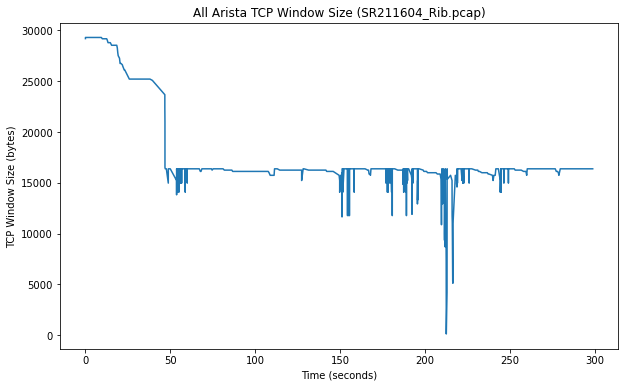

In [25]:
plotter = PcapInspect.Plotter()
plotter.plot( winSizePlotData, 'lines' )

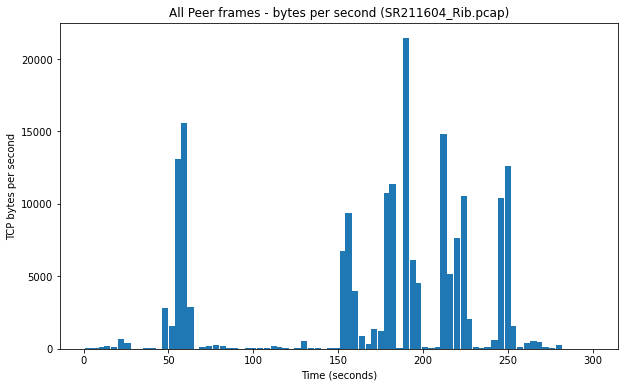

In [26]:
imageNameTemplate = pcapInspect.directory + 'Sender' +'_%s_count_' + pcapInspect.baseFilename + '.png'
plotData = frameAndBytePlotData[ 'byte' ]
plotData[ 'imageName' ] = imageNameTemplate % 'byte'
plotter.plot( plotData, 'boxes' )